In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import pearsonr, ttest_ind, mannwhitneyu

warnings.filterwarnings("ignore")

# 설치된 나눔 폰트를 사용
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [51]:
# CSV 파일 불러오기
path = r"C:\Program Files\PostgreSQL\18\data\pratice\gis.csv"
df = pd.read_csv(path)

display(df.head())

,acc_risk_area_nm,acc_risk_area_id,geom_wkt,tot_acc_cnt,tot_dth_dnv_cnt,tot_se_dnv_cnt,tot_sl_dnv_cnt,tot_wnd_dnv_cnt,cntpnt_utmk_x_crd,cntpnt_utmk_y_crd,cause_anals_ty_nm,guGun,year,gu
0,서울특별시 종로구내에서 2022년도에 반경50m 이내 다른사고8건 이상 지역,104440,"POLYGON((953818.221488349 1952394.42651939,953...",8,0,0,9,1,953847,1952452,기타,110,2022,종로구
1,서울특별시 종로구내에서 2022년도에 반경50m 이내 다른사고8건 이상 지역,104440,"POLYGON((953818.221488349 1952394.42651939,953...",8,0,0,9,1,953847,1952452,신호위반,110,2022,종로구
2,서울특별시 종로구내에서 2022년도에 반경50m 이내 다른사고8건 이상 지역,104448,"POLYGON((954556.221488349 1952352.42651939,954...",10,0,3,6,2,954574,1952431,기타,110,2022,종로구
3,서울특별시 종로구내에서 2022년도에 반경50m 이내 다른사고8건 이상 지역,104448,"POLYGON((954556.221488349 1952352.42651939,954...",10,0,3,6,2,954574,1952431,안전거리미확보,110,2022,종로구
4,서울특별시 종로구내에서 2022년도에 반경50m 이내 다른사고8건 이상 지역,104455,"POLYGON((956027.221488349 1953015.42651938,956...",11,0,2,11,3,956044,1953095,U턴중,110,2022,종로구


### 데이터 개요

이 데이터는 **서울시 각 자치구 내 반경 50m 이내에서 교통사고가 8건 이상 발생한 구역**을 추출한 것이다.  
각 구역은 **사고의 위치(Polygon)**, **발생 연도**, **사고 건수**, **사망자 및 부상자 수**,  
그리고 **주요 사고 원인 정보**를 포함하며,  
이를 기반으로 **사고 빈도 및 치명도(사망률)**를 분석할 수 있다.

## **기초 EDA**


- PostgreSQL로 적재하기 위해서 데이터 분석 전에 한번 정재하였기 때문에, 크게 전처리해야할 요소는 없음
- 그리고 해당 데이터는 행정기관에서 집계한 정확한 사고 발생 건수 및 인명 피해 규모를 반영한 계량 데이터이므로,
스케일링이나 이상치 처리와 같은 정규화 과정은 분석 목적상 불필요하다고 판단함

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967 entries, 0 to 1966
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   acc_risk_area_nm   1967 non-null   object
 1   acc_risk_area_id   1967 non-null   int64 
 2   geom_wkt           1967 non-null   object
 3   tot_acc_cnt        1967 non-null   int64 
 4   tot_dth_dnv_cnt    1967 non-null   int64 
 5   tot_se_dnv_cnt     1967 non-null   int64 
 6   tot_sl_dnv_cnt     1967 non-null   int64 
 7   tot_wnd_dnv_cnt    1967 non-null   int64 
 8   cntpnt_utmk_x_crd  1967 non-null   int64 
 9   cntpnt_utmk_y_crd  1967 non-null   int64 
 10  cause_anals_ty_nm  1967 non-null   object
 11  guGun              1967 non-null   int64 
 12  year               1967 non-null   int64 
 13  gu                 1967 non-null   object
dtypes: int64(10), object(4)
memory usage: 215.3+ KB


### 주요 컬럼 설명

| 구분 | 컬럼명 | 설명 |
|------|---------|------|
| 식별자 | `acc_risk_area_nm`, `acc_risk_area_id` | 사고 다발 지역명 및 식별 ID |
| 공간 정보 | `geom_wkt`, `cntpnt_utmk_x_crd`, `cntpnt_utmk_y_crd` | Polygon 정보(WKT), 중심점 좌표 |
| 사고 통계 | `tot_acc_cnt`, `tot_dth_dnv_cnt`, `tot_sl_dnv_cnt`, `tot_se_dnv_cnt`, `tot_wnd_dnv_cnt` | 사고 건수, 사망자, 중상자, 경상자, 부상자 수 |
| 사고 원인 | `cause_anals_ty_nm` | 주요 사고 원인 (6개 고유값) |
| 지역/연도 | `guGun`, `gu`, `year` | 자치구 코드 및 이름, 발생 연도 |

In [53]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
acc_risk_area_id,1967.0,1.081659e+05,9958.661087,98079.0,98407.0,104631.0,121764.0,122089.0
tot_acc_cnt,1967.0,2.161617e+01,14.752919,6.0,13.0,18.0,25.0,153.0
tot_dth_dnv_cnt,1967.0,1.326894e-01,0.555362,0.0,0.0,0.0,0.0,9.0
tot_se_dnv_cnt,1967.0,5.297407e+00,4.870710,0.0,2.0,4.0,7.0,58.0
tot_sl_dnv_cnt,1967.0,2.968429e+01,27.525360,4.0,14.0,22.0,35.0,278.0
tot_wnd_dnv_cnt,1967.0,2.423488e+00,3.189683,0.0,0.0,2.0,3.0,39.0
cntpnt_utmk_x_crd,1967.0,9.550845e+05,6730.789570,938069.0,949442.0,956369.0,960146.0,971158.0
cntpnt_utmk_y_crd,1967.0,1.950112e+06,5575.494923,1937824.0,1945715.0,1949793.0,1953649.0,1964987.0
guGun,1967.0,4.072013e+02,196.432214,110.0,230.0,410.0,590.0,740.0
year,1967.0,2.022998e+03,0.813165,2022.0,2022.0,2023.0,2024.0,2024.0


In [54]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()}개 고유값")

acc_risk_area_nm: 75개 고유값
geom_wkt: 822개 고유값
cause_anals_ty_nm: 6개 고유값
gu: 25개 고유값


In [55]:
print("행(row):", df.shape[0])
print("열(column):", df.shape[1])

행(row): 1967
열(column): 14


In [56]:
print("========결측치 비율========")
print((df.isnull().sum() / len(df) * 100).round(2))

========결측치 비율========
acc_risk_area_nm     0.0
acc_risk_area_id     0.0
geom_wkt             0.0
tot_acc_cnt          0.0
tot_dth_dnv_cnt      0.0
tot_se_dnv_cnt       0.0
tot_sl_dnv_cnt       0.0
tot_wnd_dnv_cnt      0.0
cntpnt_utmk_x_crd    0.0
cntpnt_utmk_y_crd    0.0
cause_anals_ty_nm    0.0
guGun                0.0
year                 0.0
gu                   0.0
dtype: float64


### 데이터 구조 요약

| 항목 | 값 |
|------|----|
| 전체 행(row) 수 | **1,967개** |
| 전체 열(column) 수 | **14개** |
| 결측치 비율 | **0.0% (결측 없음)** |

-> 결측치가 전혀 없는 **완전(clean)** 데이터셋임

## **확장 EDA**

## 1. 자치구별 사고 현황 분석

### 1-1. 자치구별 사고 건수

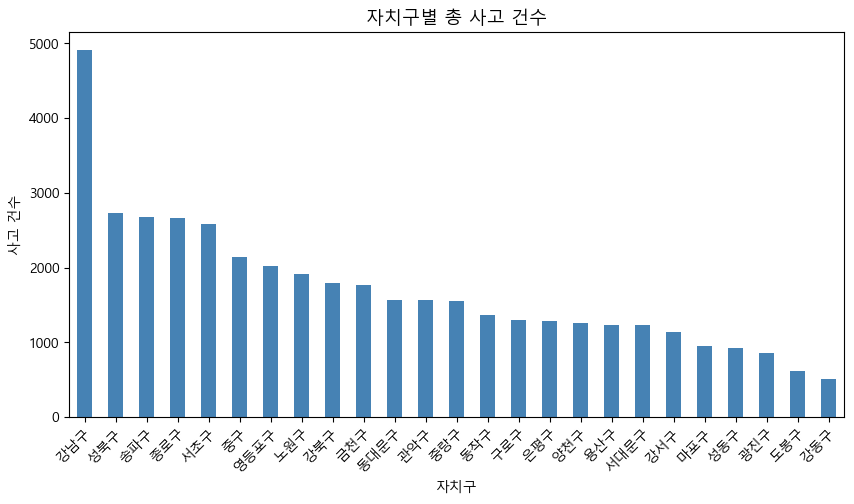

In [57]:
df_gu = df.groupby("gu")["tot_acc_cnt"].sum().sort_values(ascending=False)
df_gu.plot(kind='bar', color='steelblue', figsize=(10,5))
plt.xticks(rotation=45, ha='right', fontsize=10, rotation_mode='anchor')
plt.title("자치구별 총 사고 건수", fontsize=13)
plt.xlabel("자치구")
plt.ylabel("사고 건수")
plt.show()

- 교통사고 발생 건수로 강남구, 성북구, 송파구, 종로구, 서초구 순으로 교통 사고 구역이 많은 편이며, 특히 강남구에서 교통사고 건수가 압도적으로 많다. 
- 강남구는 인구밀도와 교통량이 높은 지역으로, 교차로 및 상업 중심지 부근 사고가 많을 가능성이 있다.  
- 반대로 강동구나 도봉구는 상대적으로 교통 흐름이 분산되어 사고 빈도가 낮은 것으로 추정된다.  
- 단순 빈도만으로는 교통안전 수준을 판단하기 어렵기 때문에,  
  이후에는 **사망자 수 및 사망률(치명도)** 를 함께 고려한 위험도 분석이 필요하다.

### 1-2. 자치구별 사망자 수 및 사망률

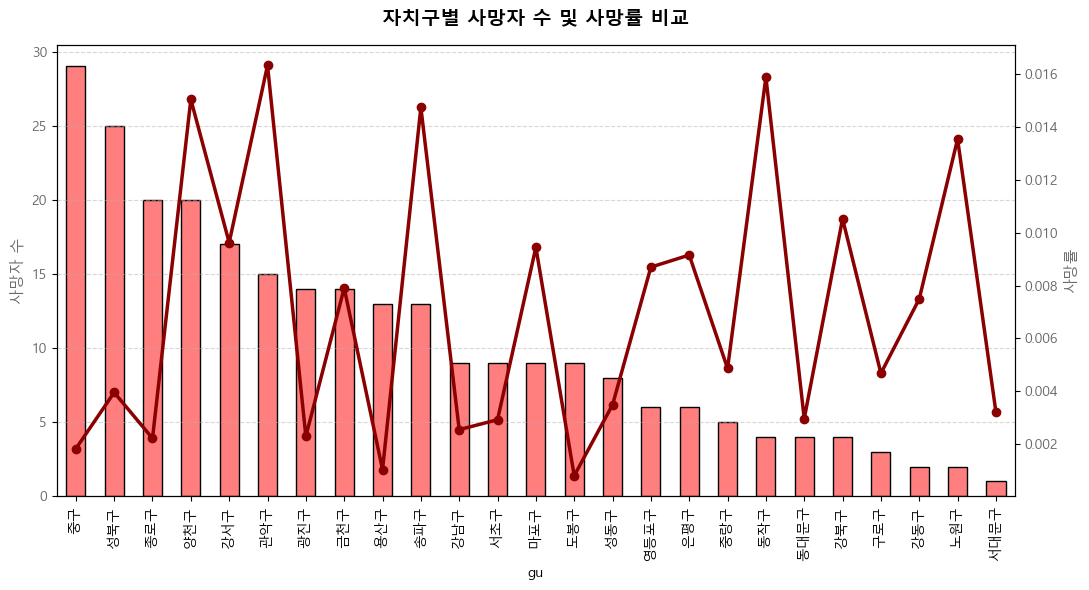

In [58]:
# 자치구별 사망자 수
df_death = df.groupby("gu")["tot_dth_dnv_cnt"].sum().sort_values(ascending=False)

# 자치구별 사망률 (사망자 수 / 사고 건수)
df_fatality = (df.groupby("gu")["tot_dth_dnv_cnt"].sum() / df.groupby("gu")["tot_acc_cnt"].sum())


# 그래프 생성
fig, ax1 = plt.subplots(figsize=(11,6))

# 막대그래프 (사망자 수)
bar_color = '#FF7F7F'   # 연한 빨강
df_death.plot(kind='bar', color=bar_color, ax=ax1, width=0.5, edgecolor='black')
ax1.set_ylabel("사망자 수", color='dimgray', fontsize=11)
ax1.tick_params(axis='y', labelcolor='dimgray')
ax1.set_title("자치구별 사망자 수 및 사망률 비교", fontsize=14, fontweight='bold', pad=15)

# 보조축 (사망률)
line_color = '#8B0000'   # 어두운 붉은색
ax2 = ax1.twinx()
ax2.plot(df_fatality.index, df_fatality.values, color=line_color, marker='o', linewidth=2.5)
ax2.set_ylabel("사망률", color='dimgray', fontsize=11)
ax2.tick_params(axis='y', labelcolor='dimgray')


plt.xticks(rotation=45, ha='right', fontsize=10, rotation_mode='anchor')
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(False)
plt.tight_layout()

plt.show()

- 중구, 성북구, 종로구가 가장 많은 사망자 수를 보임 
- 사망자 수와 사망률의 상관관계는 별로 없다고 판단됨
- 사고 건수가 최상위권이었던 강남구, 성북구는 상대적으로 낮은 사망자 수와 사망률을 보임. 아마 출·퇴근 시간에 가벼운 사고가 잦은게 원인일 가능성이 있음
- 사망자와 사망률이 둘다 높은 지표를 보이는 자치구는 양천구, 관악구, 송파구가 있으며, 특히 송파구는 사고 건수도 상위권에 있었기 때문에 특별 조치가 필요할 것으로 보임

### 1-3. 자치구별 부상자 수

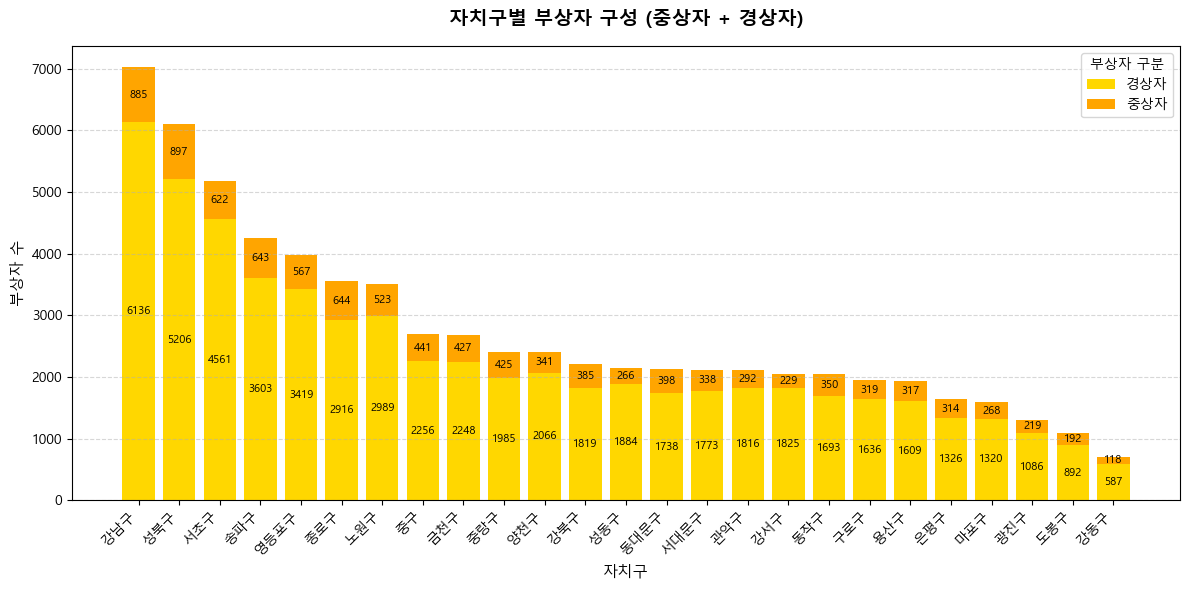

In [59]:
# 자치구별 중상자 / 경상자 수 합계 계산
df_injury = df.groupby("gu")[["tot_se_dnv_cnt", "tot_sl_dnv_cnt"]].sum()

# 합계 기준 내림차순 정렬 (중상자 + 경상자)
df_injury["total_injury"] = df_injury["tot_se_dnv_cnt"] + df_injury["tot_sl_dnv_cnt"]
df_injury = df_injury.sort_values("total_injury", ascending=False)


fig, ax = plt.subplots(figsize=(12,6))

ax.bar(df_injury.index, df_injury["tot_sl_dnv_cnt"], color='#FFD700', label='경상자')  # 노란색
ax.bar(df_injury.index, df_injury["tot_se_dnv_cnt"], 
       bottom=df_injury["tot_sl_dnv_cnt"], color='#FFA500', label='중상자')  # 주황색

for i, (sl, se) in enumerate(zip(df_injury["tot_sl_dnv_cnt"], df_injury["tot_se_dnv_cnt"])):
    ax.text(i, sl / 2, f"{int(sl)}", ha='center', va='center', color='black', fontsize=8)
    ax.text(i, sl + se / 2, f"{int(se)}", ha='center', va='center', color='black', fontsize=8)

ax.set_title("자치구별 부상자 구성 (중상자 + 경상자)", fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel("부상자 수", fontsize=11)
ax.set_xlabel("자치구", fontsize=11)
plt.xticks(rotation=45, ha='right')
ax.legend(title="부상자 구분", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- 전체적으로 강남·성북·서초·송파가 사고 및 부상자 규모가 가장 크며, 그중 성북구와 서초구는 사고의 심각도(중상자 비율) 또한 높아 단순한 사고 건수 관리뿐만 아니라 사고 치명도 완화 정책이 필요함.
- 반대로 강동·도봉·광진구 등은 비교적 안정적인 교통 환경을 보이는 지역으로, 기존의 안전 인프라를 유지하고 보완하는 방향이 효과적일 것으로 보임.

## 2. 연도별 변화 분석

### 2-1. 연도별 사고 건수 변화

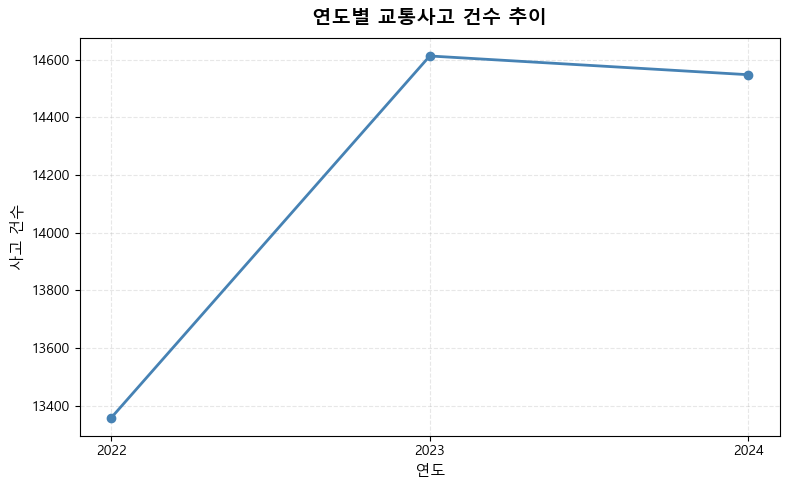

In [60]:
# 연도별 사고 건수 합계
df_year = df.groupby("year")["tot_acc_cnt"].sum()

plt.figure(figsize=(8,5))
plt.plot(df_year.index, df_year.values, marker='o', color='steelblue', linewidth=2)
plt.title("연도별 교통사고 건수 추이", fontsize=14, fontweight='bold', pad=10)
plt.xlabel("연도", fontsize=11)
plt.ylabel("사고 건수", fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(df_year.index, rotation=0)
plt.tight_layout()
plt.show()

- 2023년에 2022년에 비해 약 1200건이나 증가한 모습을 보이다가, 2024년엔 전년도보다 약간 감소한 추세를 보임
- 2022년은 코로나가 진행된 시기여서 상대적으로 사고 건수가 더 낮은 가능성이 있음

### 2-2. 연도별 지자치구별 사고 건수 

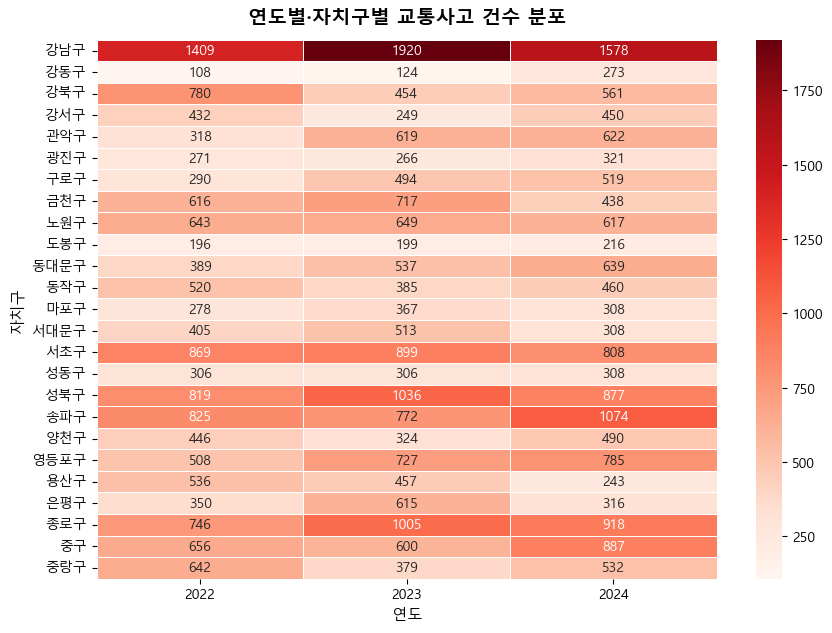

In [61]:
# 연도별·자치구별 사고 건수 집계
pivot_acc = df.pivot_table(
    index="gu", columns="year", values="tot_acc_cnt", aggfunc="sum"
)

# 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_acc, cmap="Reds", annot=True, fmt=".0f", linewidths=0.5)
plt.title("연도별·자치구별 교통사고 건수 분포", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("연도", fontsize=11)
plt.ylabel("자치구", fontsize=11)
plt.show()

- 서울의 교통사고는 지역별로 고착화된 패턴을 보이고 있으며, 특히 강남·성북·서초·송파는 매년 높은 사고 건수를 기록함
- 연도별로 보면 2023년에 사고 건수가 가장 많고, 2024년에는 일부 지역을 제외하고 다소 감소세를 보임. -> 즉, 일시적 현상이 아닌 구조적 위험 구역이 존재함을 시사함.

### 2-3. 연도별 자치구별 사망자, 중상자, 경상자 수

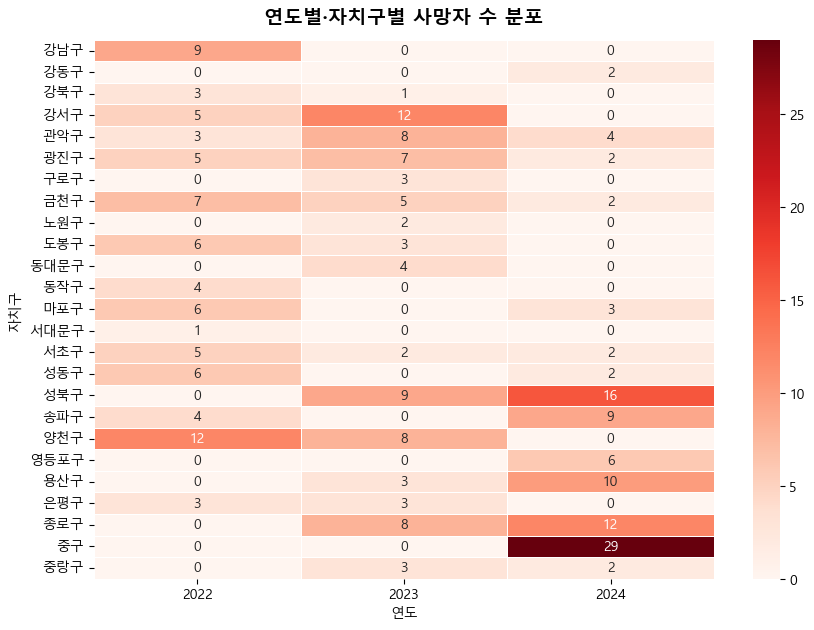

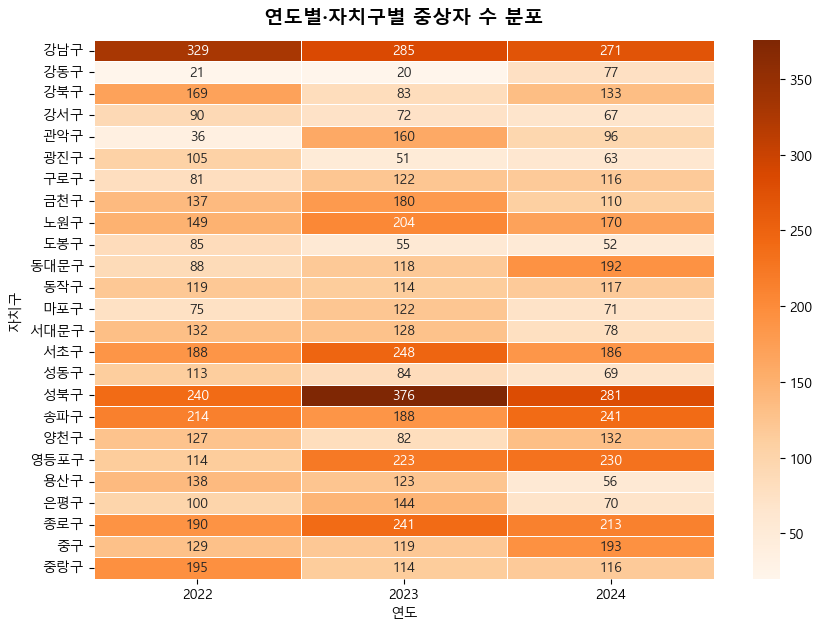

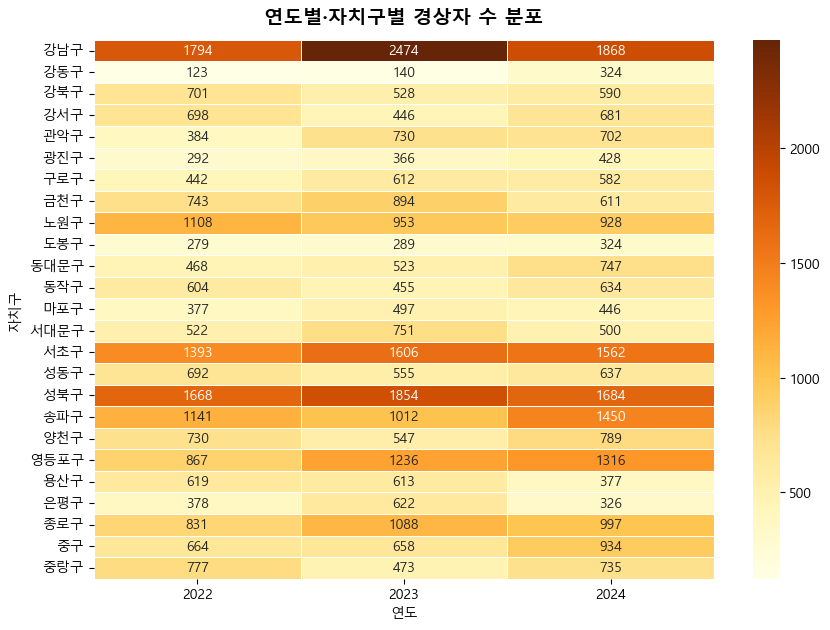

In [62]:
# 사망자
plt.figure(figsize=(10, 7))
pivot_death = df.pivot_table(index="gu", columns="year", values="tot_dth_dnv_cnt", aggfunc="sum")
sns.heatmap(pivot_death, cmap="Reds", annot=True, fmt=".0f", linewidths=0.5)
plt.title("연도별·자치구별 사망자 수 분포", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("연도")
plt.ylabel("자치구")
plt.show()

# 중상자
plt.figure(figsize=(10, 7))
pivot_severe = df.pivot_table(index="gu", columns="year", values="tot_se_dnv_cnt", aggfunc="sum")
sns.heatmap(pivot_severe, cmap="Oranges", annot=True, fmt=".0f", linewidths=0.5)
plt.title("연도별·자치구별 중상자 수 분포", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("연도")
plt.ylabel("자치구")
plt.show()

# 경상자
plt.figure(figsize=(10, 7))
pivot_minor = df.pivot_table(index="gu", columns="year", values="tot_sl_dnv_cnt", aggfunc="sum")
sns.heatmap(pivot_minor, cmap="YlOrBr", annot=True, fmt=".0f", linewidths=0.5)
plt.title("연도별·자치구별 경상자 수 분포", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("연도")
plt.ylabel("자치구")
plt.show()

- 사망자의 경우, 각 년도별로 특정 몇 구역을 빼면 특별히 높은 구역은 없음 -> 사망자 수가 불규칙성을 띠며, 아마 사망자 수가 두 자리인 곳은 대형 추돌 사고가 일어났을 확률이 높음
- 중상자의 경우, 사망자 수에 비해 조금은 일정한 추이를 유지하고 있음을 알 수 있음. 하지만 강남구, 성북구의 경우 다른 자치구에 비해 월등히 높은 중상자 수를 기록하고 있음
- 경상자의 경우, 강남구, 서초구, 성북구, 영등포구가 가장 많은 수를 보이고 있음. 아마 피크 타임에 가벼운 사고가 많이 생긴다고 추정할 수 있음. 

> 사망자를 제외한 부상자들의 경우, 연도별로 서울특별시 전체 사고 수에 맞춰서 대부분의 자치구들이 늘어나고 줄어든 모습을 보임.

## 3. 사고 원인 분석

### 3-1. 사고 원인별 사고 건수

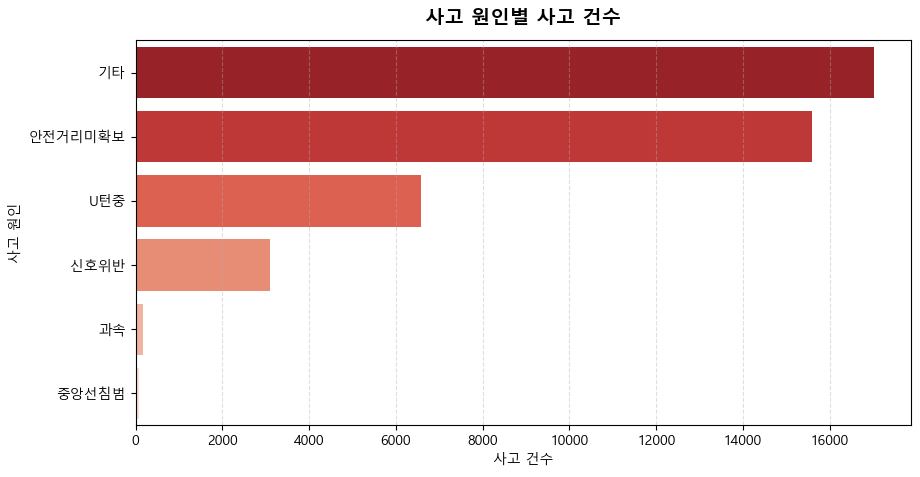

In [63]:
# 사고 원인별 사고 건수 집계
df_cause = df.groupby("cause_anals_ty_nm")["tot_acc_cnt"].sum().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10,5))
sns.barplot(x=df_cause.values, y=df_cause.index, palette="Reds_r")

plt.title("사고 원인별 사고 건수", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("사고 건수")
plt.ylabel("사고 원인")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

- 기타항목이 가장 많은데, 아마 대표적인 원인들 외에도 여러 복합적인 이유들을 종합하여 낸 산출물일 것으로 예상됨
- 기타항목을 제외한다면, 안전거리미확보가 가장 압도적으로 보이고 있음. 
- 그 다음으로 U턴중, 신호위반, 과속, 중앙선침범 순으로 보이며, 과속과 중앙선침범은 압도적으로 낮은 건수를 보이고 있음.

> 항목들의 건수를 종합해보면, 안전거리미확보나 U턴중, 신호위반의 경우, 운전자가 주위를 보지 않고 부주의하게 운전해서 발생한 것으로 추정되며,
> 중앙선침범의 경우, 급발진이나 음주운전 등 특수한 케이스라고 추정됨.

### 3-2. 사고 원인별 사망률

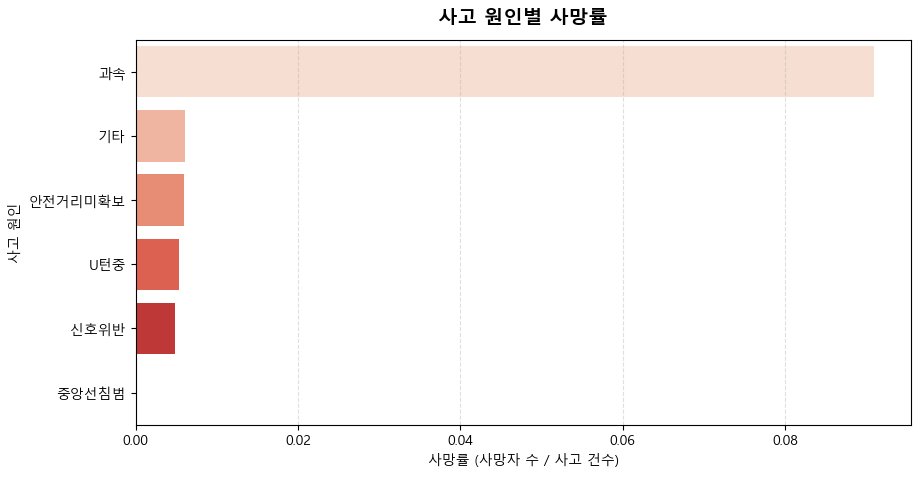

In [64]:
# 사고 원인별 사망률 계산
df_cause_fatality = (
    df.groupby("cause_anals_ty_nm")
    .apply(lambda x: x["tot_dth_dnv_cnt"].sum() / x["tot_acc_cnt"].sum())
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=df_cause_fatality.values,
    y=df_cause_fatality.index,
    palette="Reds"
)

plt.title("사고 원인별 사망률", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("사망률 (사망자 수 / 사고 건수)")
plt.ylabel("사고 원인")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

- 사고 건수가 상대적으로 낮았던 과속이 사망률이 다른 사건들에 비해 압도적으로 높음을 보여줌 
-> 즉, 과속의 경우 속도로 인한 충돌의 크기가 강하여 상대적으로 손을 쓰기도 전에 사망할 가능성이 높음을 보임
- 그 외 중앙선침범을 제외하고 나머지 원인들은 비슷한 비율을 보이고 있음

### 3-3. 연도별 주요 원인 추이

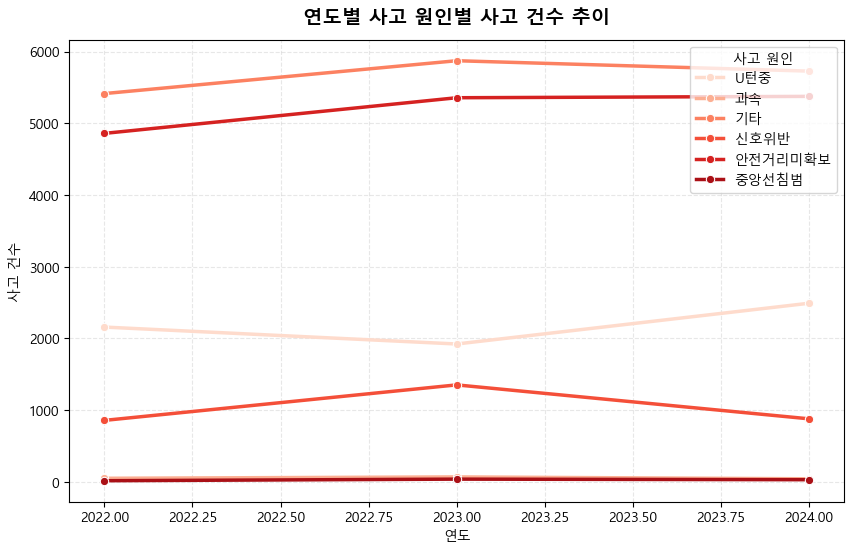

In [65]:
# 연도별 사고 원인별 사고 건수 집계
df_cause_year = (
    df.groupby(["year", "cause_anals_ty_nm"])["tot_acc_cnt"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_cause_year,
    x="year",
    y="tot_acc_cnt",
    hue="cause_anals_ty_nm",
    marker="o",
    linewidth=2.5,
    palette="Reds"
)

plt.title("연도별 사고 원인별 사고 건수 추이", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("연도")
plt.ylabel("사고 건수")
plt.grid(alpha=0.3, linestyle="--")
plt.legend(title="사고 원인", loc="upper right")
plt.show()

- U턴중과 거의 0에 수렴하는 중앙선침범을 제외한 나머지 항목들은 연도별 교통사고 건수와 비슷한 추이를 보이고 있음

## 4. Top 5 사고 다발 지역

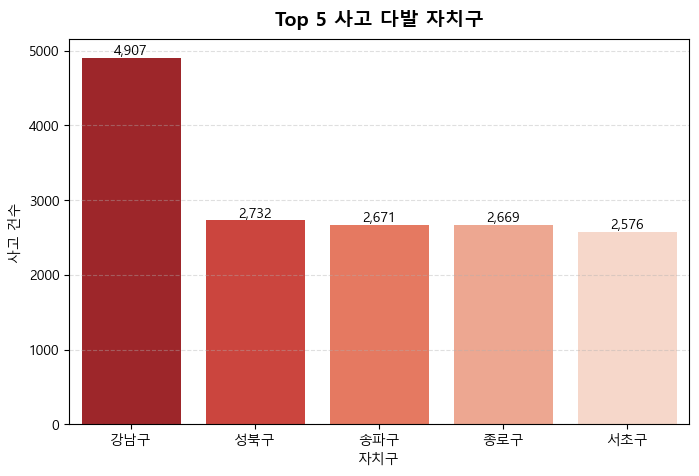

In [66]:
# 자치구별 총 사고 건수 계산
df_top_gu = (
    df.groupby("gu")["tot_acc_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_top_gu,
    x="gu",
    y="tot_acc_cnt",
    palette="Reds_r"
)

for index, value in enumerate(df_top_gu["tot_acc_cnt"]):
    plt.text(index, value + 0.5, f"{value:,}", ha='center', va='bottom', fontsize=10)

plt.title("Top 5 사고 다발 자치구", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("자치구")
plt.ylabel("사고 건수")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

## 5. 사망률 기준 Top 5 위험 자치구 

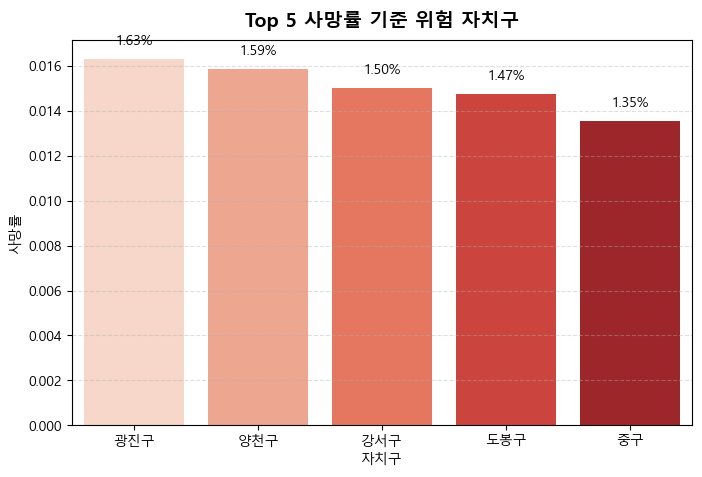

In [67]:
# 자치구별 사망자 수와 사고 건수 집계
df_risk = (
    df.groupby("gu")[["tot_dth_dnv_cnt", "tot_acc_cnt"]]
    .sum()
    .reset_index()
)

# 사망률 계산
df_risk["fatality_rate"] = df_risk["tot_dth_dnv_cnt"] / df_risk["tot_acc_cnt"]
df_risk = df_risk.sort_values("fatality_rate", ascending=False).head(5)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_risk,
    x="gu",
    y="fatality_rate",
    palette="Reds"
)

for index, value in enumerate(df_risk["fatality_rate"]):
    plt.text(index, value + 0.0005, f"{value:.2%}", ha='center', va='bottom', fontsize=10)

plt.title("Top 5 사망률 기준 위험 자치구", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("자치구")
plt.ylabel("사망률")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

## 6. 사고 건수 대비 사망 산포도

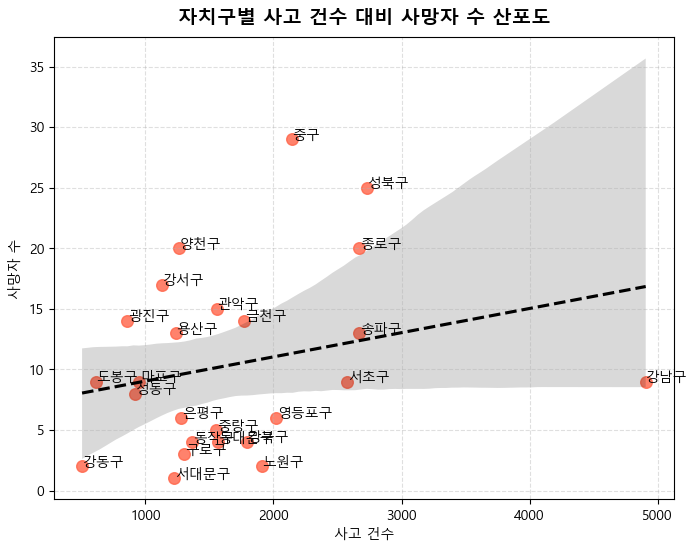

In [68]:
# 자치구별 집계
df_scatter = (
    df.groupby("gu")[["tot_acc_cnt", "tot_dth_dnv_cnt"]]
    .sum()
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.regplot(
    data=df_scatter,
    x="tot_acc_cnt",
    y="tot_dth_dnv_cnt",
    scatter_kws={"s":70, "alpha":0.8, "color":"tomato"},
    line_kws={"color":"black", "linestyle":"--"}
)

gu = df_scatter.sort_values("tot_dth_dnv_cnt", ascending=False)
for _, row in gu.iterrows():
    plt.text(row["tot_acc_cnt"]+5, row["tot_dth_dnv_cnt"], row["gu"], fontsize=10, color="black")

plt.title("자치구별 사고 건수 대비 사망자 수 산포도", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("사고 건수")
plt.ylabel("사망자 수")
plt.grid(alpha=0.4, linestyle="--")
plt.show()

## 통계 분석

### 가설1: 사고 건수가 많을 자치구일수록 사망자 수도 많다.

In [69]:
# 자치구별 합계
df_corr = df.groupby("gu")[["tot_acc_cnt", "tot_dth_dnv_cnt"]].sum()

# 상관계수 및 p-value
corr, p_value = pearsonr(df_corr["tot_acc_cnt"], df_corr["tot_dth_dnv_cnt"])

print(f"상관계수: {corr:.3f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("유의미한 상관관계가 있음")
else:
    print("유의미한 상관관계가 없음")

상관계수: 0.246
p-value: 0.2355
유의미한 상관관계가 없음


### 가설2: 사망률과 중상자 비율은 서로 상관성을 가질 것이다.

In [70]:
# 자치구별 합계
df_city = df.groupby("gu")[["tot_acc_cnt","tot_dth_dnv_cnt","tot_se_dnv_cnt"]].sum()

# 비율 계산
df_city["fatality_rate"] = df_city["tot_dth_dnv_cnt"] / df_city["tot_acc_cnt"]
df_city["serious_rate"] = df_city["tot_se_dnv_cnt"] / df_city["tot_acc_cnt"]

# 상관 분석
r, p = pearsonr(df_city["fatality_rate"], df_city["serious_rate"])
print(f"상관계수: {r:.3f}, p-value: {p:.4f}")

if p < 0.05:
    print("유의미한 양의 상관관계가 있음")
else:
    print("통계적으로 유의한 관계는 없음")

상관계수: 0.074, p-value: 0.7268
통계적으로 유의한 관계는 없음


### 가설 3: 도심 지역은 외곽 지역보다 사망률이 낮을 것이다.

In [71]:
urban = ["종로구", "중구", "용산구", "성동구", "광진구", "마포구", "서대문구", "성북구", "동대문구"]
outer = ["노원구", "도봉구", "강북구", "은평구", "강서구", "양천구", "구로구", "금천구", "관악구", 
          "동작구", "서초구", "강남구", "송파구", "강동구"]

df_city["group"] = df_city.index.map(
    lambda x: "urban" if x in urban else ("outer" if x in outer else "other")
)

urban_data = df_city[df_city["group"]=="urban"]["fatality_rate"]
outer_data = df_city[df_city["group"]=="outer"]["fatality_rate"]

t_stat, p_val = ttest_ind(urban_data, outer_data, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("도심과 외곽 간 사망률 차이가 통계적으로 유의함")
else:
    print("도심과 외곽 간 사망률 차이는 통계적으로 유의하지 않음")

T-statistic: 1.056, p-value: 0.3048
도심과 외곽 간 사망률 차이는 통계적으로 유의하지 않음


### 가설4: 연도별 교통사고 건수는 사망자 및 부상자 수도 그 추이에 맞춰서 변화한다.

사고건수 ↔ 사망자수 상관계수: 0.531 (p=0.6436)
사고건수 ↔ 부상자수 상관계수: 0.999 (p=0.0276)


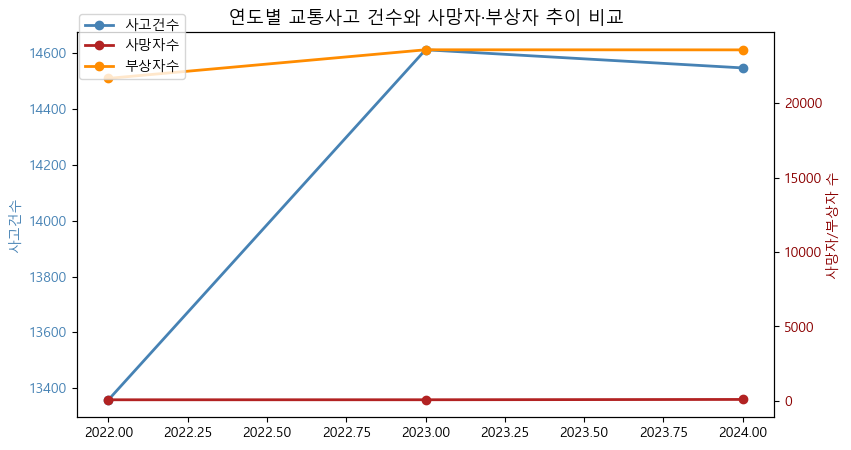

In [72]:
# 연도별 요약 (사고, 사망, 중상, 경상자 합)
df_year = (
    df.groupby("year")[["tot_acc_cnt", "tot_dth_dnv_cnt", "tot_se_dnv_cnt", "tot_sl_dnv_cnt"]]
    .sum()
    .reset_index()
)

# 전체 부상자 합산
df_year["total_injuries"] = df_year["tot_se_dnv_cnt"] + df_year["tot_sl_dnv_cnt"]

# 상관관계 분석
r_death, p_death = pearsonr(df_year["tot_acc_cnt"], df_year["tot_dth_dnv_cnt"])
r_injury, p_injury = pearsonr(df_year["tot_acc_cnt"], df_year["total_injuries"])

print(f"사고건수 ↔ 사망자수 상관계수: {r_death:.3f} (p={p_death:.4f})")
print(f"사고건수 ↔ 부상자수 상관계수: {r_injury:.3f} (p={p_injury:.4f})")

# 시각화
fig, ax1 = plt.subplots(figsize=(9,5))

# 사고건수 (왼쪽 축)
ax1.plot(df_year["year"], df_year["tot_acc_cnt"], color="steelblue", marker="o", linewidth=2, label="사고건수")
ax1.set_ylabel("사고건수", color="steelblue")
ax1.tick_params(axis='y', labelcolor="steelblue")

# 사망자/부상자 (오른쪽 축)
ax2 = ax1.twinx()
ax2.plot(df_year["year"], df_year["tot_dth_dnv_cnt"], color="firebrick", marker="o", linewidth=2, label="사망자수")
ax2.plot(df_year["year"], df_year["total_injuries"], color="darkorange", marker="o", linewidth=2, label="부상자수")
ax2.set_ylabel("사망자/부상자 수", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("연도별 교통사고 건수와 사망자·부상자 추이 비교", fontsize=13)
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.93))
plt.show()

- 사망자수는 사고건수와 관계가 없지는 않지만, 유의미한 수준은 아니고, 부상자수는 사고건수의 추이에 거의 부합하게 따름을 보임

### 가설5: 사고 원인이 복합적일수록 사고의 치명도(사망률)가 높다.

In [77]:
# 기타 항목 제거
df_filtered = df[df["cause_anals_ty_nm"] != "기타"]

# 사고별 원인 개수 계산
df_cause = (
    df_filtered.groupby("acc_risk_area_id")["cause_anals_ty_nm"]
    .nunique()
    .reset_index(name="cause_count")
    )

df_filtered = df_filtered.merge(df_cause, on="acc_risk_area_id", how="left")

# 단일/복합 구분
df_filtered["cause_type"] = df_filtered["cause_count"].apply(
    lambda x: "복합사고" if x > 1 else "단일사고")

# 사망률 계산
df_filtered["fatality_rate"] = (
    df_filtered["tot_dth_dnv_cnt"] / df_filtered["tot_acc_cnt"]
).fillna(0)


summary = (
    df_filtered.groupby("cause_type")[["tot_dth_dnv_cnt", "tot_se_dnv_cnt", "fatality_rate"]]
    .mean()
    .reset_index()
)

print(summary)

  cause_type  tot_dth_dnv_cnt  tot_se_dnv_cnt  fatality_rate
0       단일사고         0.103015        4.296482       0.005809
1       복합사고         0.155080        6.088235       0.007741


In [81]:
# 단일/복합 사고 분리
fatal_single = df_filtered[df_filtered["cause_type"] == "단일사고"]["fatality_rate"].dropna()
fatal_multi = df_filtered[df_filtered["cause_type"] == "복합사고"]["fatality_rate"].dropna()

# 독립표본 t-검정이 유의하면 그대로 쓰고, 아니라면 맨-휘트니 검정 결과값을 사용함
stat, p = ttest_ind(fatal_single, fatal_multi, equal_var=False)
if p > 0.05: 
    stat, p = mannwhitneyu(fatal_single, fatal_multi, alternative="two-sided")
else:
    stat, p = ttest_ind(fatal_single, fatal_multi, equal_var=False)


print(f"통계량 = {stat:.3f},  p-value = {p:.3f}")

통계량 = 143780.000,  p-value = 0.057


- 단일/복합 사고 간의 사망률 차이는 유의수준 5%에서는 유의하진 않지만, 0.05에 근접한 값을 가지므로, 약한 차이 존재 가능성을 배제할 순 없음

In [82]:
corr, p = pearsonr(df_filtered["cause_count"], df_filtered["fatality_rate"])
print("피어슨 상관관계 결과")
print(f"상관계수 = {corr:.3f},  p-value = {p:.4f}")

피어슨 상관관계 결과
상관계수 = 0.025,  p-value = 0.4045


- 사고 원인 개수가 많을수록 사망률이 높아질 것이라는 가설은 기각되었다고 볼수 있는데, 두 변수의 상관계수는 거의 0에 가깝고, p-value 또한 0.4로 유의하지 않기 때문에 두 변수 간에는 사실상 통계적으로 유의한 관계가 없다고 볼 수 있음